# p-alpha elastic scattering 

__Ref: R. Higa, arxiv:1001.0540__

p-alpha has resonance in P2/3 channel at E_p ~ 1.97 MeV with width~ 1.23 MeV. 


*  Effective Range expansion is a phenomenological and should be okay regardless the details of the interaction. 

*  Effective Field theory use EFT coupling strengths. To explain the phenomena, sometimes it requires fine-tuning of coupling parameters. In other words, strictly speaking, power counting of EFT is about the coupling parameters and the order of diagrams. 

* At leading order Lagrangian, we would have two parameters, $\Delta$ and $g$. 

* From the dimensional analysis, we expect $\Delta \sim \frac{M_{hi}^2}{2m}$ at natural case. In this case, the LO dimer propagator is $1/\Delta$ without any kinematic terms. This power counting implies the loop corrections are perturbative and no-resummation is necessary. (One can even treat the unitary term $-ik$ as a perturbative correction. No bound state or resonnance. )

* In unnatural case, with $M_{lo}$ scale, we may consider two cases, $\Delta \sim \frac{M_{hi}M_{lo}}{2m}$ or $\Delta \sim \frac{M_{lo}^2}{2m}$. In these case, the loop diagrams have to be re-summed. (According to power counting, loop diagram is in the same order as tree). Then the unitary term should be in the denominator of LO amplitude and allows shallow bound state or resonnance.  

* In case of $\Delta \sim \frac{M_{lo}^2}{2m}$. P-wave resonnance requires both $1/a$ and $r$ to be fine tuned. (All three terms including unitary term are the same order.) 

* $\Delta \sim \frac{M_{lo} M_{hi}}{2m}$ power counting is similar to previous case. But, for P-wave, only one parameter have to be fine tuned and allows narrow width of resonnance. (In this case, unitary term is smaller than two-terms and only combination $a*r$ have to be fine tuned.)  

* There is another __kinematic fine-tuning__ near resonnance where higher order terms to be re-summed near resonnance momentum.  

## Import and define constants

In [1]:
import numpy
import numpy as np

import matplotlib.pyplot as plt

import scipy 
import scipy.special
from scipy.special import factorial

from sympy.physics.sho import E_nl
from sympy import symbols
from sympy.physics.sho import R_nl
from sympy import var
from sympy.physics.wigner import wigner_9j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import clebsch_gordan

from functools import lru_cache
import myutil

hbarc = 197.326968 # MeV.fm 
fm = 1/hbarc # MeV^-1 
amu = 931.4940954 # MeV
mass_p  = 938.272    
mass_n  = 939.5653
mass_N = (mass_p+mass_n)/2.0
alpha = 1.0/137.03599
mass_alpha = 3727.4 # MeV 
mass_12C= 12*amu # amu or mass_N 

# show Fit result with error bar 
def print_fit_summary(p_para,p_cov,ERE_L=None):
    """
    print results of curve_fit with error estimation
    """
    dim=len(p_para)
    for i in range(dim):
        print('para[%i] = %e +/- %e'%(i,p_para[i],np.sqrt(abs(p_cov[i,i]))) )
    
    if ERE_L:
        print('*--mass scale--- for L={}*'.format(ERE_L))
        fac = [1,0.5,0.25,1] #coefficient   
        for i in range(dim): # convert into powers
            print('scale[%i]= %f'%(i,(fac[i]*np.abs(p_para[i]))**(1./(2*L+1-2*i)) )    )
    return  

## specify p+alpha system

In [2]:
#----------p + alpha system 
reduced_mass= mass_alpha*mass_p/(mass_alpha+mass_p)
charge_product = 1*2
k_C = charge_product*alpha*reduced_mass
print('k_C=',k_C)

k_C= 10.939964351510294


## Functions related with Coulomb scattering 

  1.  sigma_l(eta) : Coulomb phase shift

  2. C_l(eta) : Coulomb related factor

  3. h_l(eta) : Coulomb related function

  4. f_c(theta,eta) : Coulomb scattering amplitude 



In [3]:
def Coulomb_eta(charge_product,reduced_mass,pcm):
    """
        eta = Z1*Z2*alpha_em*(reduced_mass)/p 
    """
    return charge_product*alpha*(reduced_mass)/pcm 

def Coulomb_phaseshift(L,eta):
    return np.angle(scipy.special.gamma(L+1+1j*eta))

def Coulomb_factor(L,eta):
    """
    Gamow-Sommerfeld factor C_l(eta)**2
    """
    return np.exp(-np.pi*eta)*scipy.special.gamma(L+1+1j*eta)*scipy.special.gamma(L+1-1j*eta)

def Coulomb_h_l(L,eta,pcm):
    """
    h_l(eta)
    
    Note : not well defined numerically at eta =0.
    """
    temp=pcm**(2*L)*Coulomb_factor(L,eta)/Coulomb_factor(0,eta)
    out =temp*(scipy.special.digamma(1j*eta)+1./(2*1j*eta)-np.log(1j*eta))
    return out 

def Coulomb_scattering_amplitude(theta,eta,kcm):
    """
    Coulomb scattering amplitude for spin-less particle
    """
    temp1 = -eta/(2*kcm*np.sin(theta/2.0)**2)
    temp2 = np.exp(-1j*eta*np.log(np.sin(theta/2.0)**2)+2*1j* Coulomb_phaseshift(0,eta)   )
    return temp1*temp2

def phase_shift_from_fL(kcm,f_L):
    # phase shift in radian 
    return np.real(np.log(1.0+2*1j*kcm*f_L)/(2*1j))

def positive_phase(phase):
    """
    convert negative phase shift(degree) 
    to positive one by adding 180 degree 
    """
    return (phase < 0)*(phase+180.0)+(phase >=0)*phase

## Phase shift data

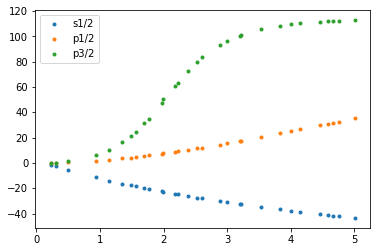

In [4]:
PhaseShift =  myutil.read_fresco_res('p_alpha_phase.txt') ;
PhaseShift[0] = np.array(PhaseShift[0])
elab_exp = PhaseShift[0][:,0];
phase_0p_exp = PhaseShift[0][:,1]; # s1/2
phase_1m_exp = PhaseShift[0][:,2]; # p1/2
phase_1p_exp = PhaseShift[0][:,3]; # p3/2
plt.plot(elab_exp,phase_0p_exp,'.',label='s1/2')
plt.plot(elab_exp,phase_1m_exp,'.',label='p1/2')
plt.plot(elab_exp,phase_1p_exp,'.',label='p3/2')
plt.legend()

## ERE T-matrix expression

$$ T_L =-\frac{2\pi}{\mu} f_L e^{2i\sigma_L} P_L(\theta)= -\frac{2\pi}{\mu}\frac{C^2_L(\eta) k^{2l} e^{2i\sigma_L} P_L(\theta)}{-1/a_L +r_L k^2/2 -P_L k^4/4 - 2k_C h_L(\eta)}$$

scattering amplitude $f_L$ can be used to obtain cross section and phase shift.



In [5]:
def scattering_amplitude_ERE(kcm, L,ERE_para= None):
    # ERE para = (a_L, r_L, P_L) in fm power units 
    a_L = ERE_para[0]/hbarc**(2*L+1) # to MeV power units 
    r_L = ERE_para[1]*hbarc**(2*L-1)
    P_L = ERE_para[2]*hbarc**(2*L-3) 
    eta = Coulomb_eta(charge_product,reduced_mass,kcm)
    C_L_sqr = Coulomb_factor(L,eta) # C_L^2
    numerator = C_L_sqr*kcm**(2*L)
    denominator = -1./a_L +0.5*r_L*kcm**2-0.25*P_L*kcm**4 - 2*k_C*Coulomb_h_l(L,eta,kcm) 
    return numerator/denominator  

## EFT T-matrix expression

For p-alpha, s1/2 and p1/2 channel does not have resonnance. 
Thus, one can treat effective range term as a NLO. 
$$T_0 = -\frac{2\pi}{\mu}\frac{C_\eta^2 e^{2i\sigma_0}}{-1/a_0-2 k_C h_0(\eta)}( 1- \frac{r_0 k^2/2}{(-1/a_0-2 k_C h_0(\eta))} )$$   

on the other hand, p3/2 has a resonance and the LO should include effective range. 
$$T_1 = -\frac{2\pi}{\mu}\frac{C^{(1)2}_\eta e^{2i\sigma_1} k^2 P_1(\theta)}{-1/a_1+r_1 k^2/2 -2 k_C h_1(\eta)}
         ( 1+ \frac{P_1 k^4/4}{(-1/a_1+r_1 k^2/2 -2 k_C h_1(\eta))} )$$   

__Note that this form treats NLO correction, P_1 as a perturbative correction__

However, this form will not be good near resonnance. 
Near resonnance, one have to resum the NLO corrections into denominator,
which is the same as ERE form.

In [6]:
def scattering_amplitude_EFT(kcm, L,ERE_para= None):
    # ERE para = (a_L, r_L, P_L) in fm power units 
    a_L = ERE_para[0]/hbarc**(2*L+1) # to MeV power units 
    r_L = ERE_para[1]*hbarc**(2*L-1)
    P_L = ERE_para[2]*hbarc**(2*L-3) 
    eta = k_C/kcm
    C_L_sqr = Coulomb_factor(L,eta) # C_L^2
    hL_eta= Coulomb_h_l(L,eta,kcm)
    
    numerator = C_L_sqr*kcm**(2*L)
    if L==0:
        f_L = numerator/(-1/a_L - 2*k_C*hL_eta)*(1-0.5*r_L*kcm**2/(-1/a_L - 2*k_C*hL_eta)) 
    elif L==1:
        f_L = numerator/(-1/a_L+0.5*r_L*kcm**2 - 2*k_C*hL_eta)*(1+0.25*P_L*kcm**4/(-1/a_L+0.5*r_L*kcm**2 - 2*k_C*hL_eta)) 
    return f_L 

## parameters from reference 

s1/2 parameters

           a_0+              r_0+
    ERE    4.97+/-0.12       1.295+/-0.082
    LO     7.4 (+8.0-2.2) 
    NLO    4.81(+0.05-0.21)  1.7(+1/2,-0.8)
    
    
p3/2 parameters

             a_1+                r_1+          P_1+ 
     ERE   -44.83+/-0.51      -0.365+/-0.013   -2.39+/-0.15
     LO    -58.0              -0.15   
     NLO   -44.5              -0.4             -2.8  




    
    
       

In [7]:
ERE_0p_ERE = (4.97,1.295,0.0);
ERE_0p_LO  = (7.4, 0.0, 0.0);
ERE_0p_NLO = (4.81,1.7,0.0);

ERE_1p_ERE = (-44.83,-0.365, -2.39);
ERE_1p_LO  = (-58.0, -0.15, 0.0);
ERE_1p_NLO = (-44.5, -0.4,-2.8);

### S1/2 phase shift from given parameters (no fitting is done here)

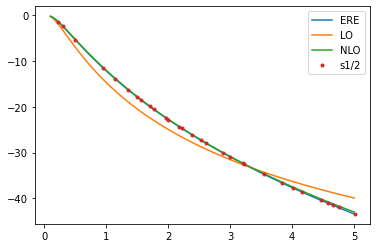

In [8]:
# Phase Shift plot 
elab = np.linspace(0.1,5.0,100)
ecm  = elab*reduced_mass/mass_p 
kcm  = np.sqrt(2*reduced_mass*ecm)

ff = scattering_amplitude_ERE(kcm, 0 ,ERE_para= ERE_0p_ERE);
phase_0p = phase_shift_from_fL(kcm,ff)*180/np.pi

ff = scattering_amplitude_EFT(kcm, 0 ,ERE_para= ERE_0p_LO);
phase_0p_LO = phase_shift_from_fL(kcm,ff)*180/np.pi
ff = scattering_amplitude_EFT(kcm, 0 ,ERE_para= ERE_0p_NLO);
phase_0p_NLO = phase_shift_from_fL(kcm,ff)*180/np.pi

plt.plot(elab,phase_0p,label='ERE')
plt.plot(elab,phase_0p_LO,label='LO')
plt.plot(elab,phase_0p_NLO,label='NLO')
plt.plot(elab_exp,phase_0p_exp,'.',label='s1/2')
plt.legend()

### P3/2 phase shift from given parameters (no fitting is done here)

result shows discrepancy for larger energy.
expansion around resonance may be appropriate.

__Suprisingly, in constrast to the expectaion, EFT form seems to be okay even near resonance.__


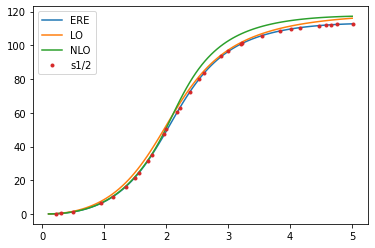

In [9]:
# Phase Shift plot 
elab = np.linspace(0.1,5.0,100)
ecm  = elab*reduced_mass/mass_p 
kcm  = np.sqrt(2*reduced_mass*ecm)

ff = scattering_amplitude_ERE(kcm, 1 ,ERE_para= ERE_1p_ERE);
phase_1p = positive_phase( phase_shift_from_fL(kcm,ff)*180/np.pi)

ff = scattering_amplitude_EFT(kcm, 1 ,ERE_para= ERE_1p_LO);
phase_1p_LO = positive_phase(phase_shift_from_fL(kcm,ff)*180/np.pi)

ff = scattering_amplitude_EFT(kcm, 1 ,ERE_para= ERE_1p_NLO);
phase_1p_NLO = positive_phase(phase_shift_from_fL(kcm,ff)*180/np.pi)

plt.plot(elab,phase_1p,label='ERE')
plt.plot(elab,phase_1p_LO,label='LO')
plt.plot(elab,phase_1p_NLO,label='NLO')
plt.plot(elab_exp,phase_1p_exp,'.',label='s1/2')
plt.legend()

## To do?

Since the ERE_para of EFT does not give good results, one may 

1. Try with resonance expansion form 
2. Try to fit directly to obtain parameters

In [10]:
# Fit ERE_form 
def fit_function_ERE(elab, p0=0,p1=0,p2=0,p3=0):
    ecm  = elab*reduced_mass/mass_p 
    kcm  = np.sqrt(2*reduced_mass*ecm)
    ff = scattering_amplitude_ERE(kcm, 1 ,ERE_para=(p0,p1,p2,p3))
    phase_shift = positive_phase(phase_shift_from_fL(kcm,ff)*180/np.pi)
    return phase_shift

def fit_function_EFT(elab, p0=0,p1=0,p2=0,p3=0):
    ecm  = elab*reduced_mass/mass_p 
    kcm  = np.sqrt(2*reduced_mass*ecm)
    ff = scattering_amplitude_EFT(kcm, 1 ,ERE_para=(p0,p1,p2,p3))
    phase_shift = positive_phase(phase_shift_from_fL(kcm,ff)*180/np.pi)
    return phase_shift

def fit_phase(x= elab_exp, y=phase_1p_exp,yerr = None, fit_function = fit_function_ERE,p0= None):
    p_para0, pcov0 = scipy.optimize.curve_fit(fit_function, x, y, p0= p0, sigma=yerr )
    #print(p_para0)
    print_fit_summary(p_para0,pcov0)
    yfit = fit_function(x,*p_para0)
    plt.figure()
    plt.plot(x,y,'*')
    plt.plot(x,yfit);
    plt.xlabel('elab');plt.ylabel('degree');
    plt.grid();
    return p_para0, pcov0 

### fit with ERE form

para[0] = -4.520471e+01 +/- 3.900929e-01
para[1] = -3.579155e-01 +/- 8.703723e-03
para[2] = -2.321414e+00 +/- 9.358797e-02
55.39346516053043 35.313187591638965 2205.2912781678356


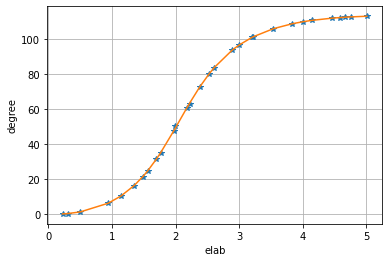

In [11]:
para, pcov = fit_phase(p0=[-40,-1,-1],fit_function = fit_function_ERE)
L=1;
print(np.abs(1/para[0])**(1./(2*L+1))*hbarc,  np.abs(0.5*para[1])**(1./(2*L-1))*hbarc, np.abs(0.25*para[1])**(1./(2*L-3))*hbarc)

### Fit with EFT at LO

para[0] = -5.641048e+01 +/- 9.036859e-01
para[1] = -1.474755e-01 +/- 7.059297e-03
51.45171417004602 14.550442716878392


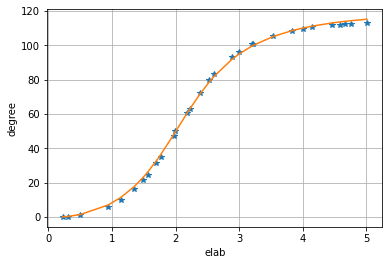

In [12]:
para, pcov = fit_phase(p0=[-40,-1],fit_function = fit_function_EFT)
L=1;
print(np.abs(1/para[0])**(1./(2*L+1))*hbarc,  np.abs(0.5*para[1])**(1./(2*L-1))*hbarc)

### Fit with EFT up to NLO

para[0] = -4.896691e+01 +/- 3.348796e-01
para[1] = -3.049350e-01 +/- 7.519269e-03
para[2] = -2.311657e+00 +/- 1.480127e-01
53.93684666163369 30.08595347903326 2588.445955499377


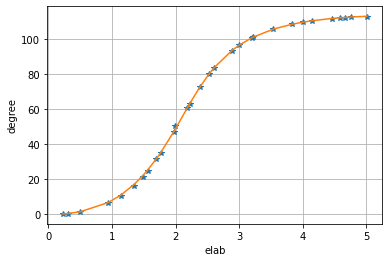

In [13]:
para, pcov = fit_phase(p0=[-50,-0.1,-0.1],fit_function = fit_function_EFT)
L=1;
print(np.abs(1/para[0])**(1./(2*L+1))*hbarc,  np.abs(0.5*para[1])**(1./(2*L-1))*hbarc, np.abs(0.25*para[1])**(1./(2*L-3))*hbarc)

__In case of p+alpha scattering p3/2 channel,
both ERE and EFT form gives good fits and 
the parameter values are in reasonanble agreement with power counting expectation.__

# Revisit p+12C P3/2 channel

Let us try to use the same formula for p+12C case with R-matrix phase shift

k_C= 37.900090131505706


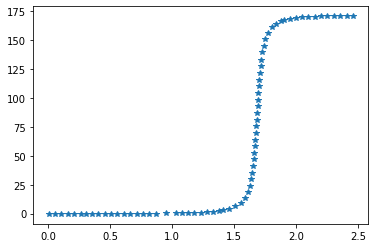

In [14]:
#Switch to p+12C system
#----------p + 12C system 
reduced_mass= mass_12C*mass_p/(mass_12C+mass_p)
charge_product = 1*6
k_C = charge_product*alpha*reduced_mass
print('k_C=',k_C)

#--- read data 
p12C =  myutil.read_fresco_res('12C_scattering/Azuma_PhaseShift.txt') ;
p12C_1p = np.array(p12C[2]) #p3/2 phase shift 
plt.plot(p12C_1p[:,0],p12C_1p[:,1],'*' )

In [15]:
# redefine function to be able to 4-parameter fits

def scattering_amplitude_ERE(kcm, L,ERE_para= None):
    # ERE para = (a_L, r_L, P_L) in fm power units 
    a_L = ERE_para[0]/hbarc**(2*L+1) # to MeV power units 
    r_L = ERE_para[1]*hbarc**(2*L-1)
    P_L = ERE_para[2]*hbarc**(2*L-3) 
    q_L = ERE_para[3]*hbarc**(2*L-5)   
    eta = Coulomb_eta(charge_product,reduced_mass,kcm)
    C_L_sqr = Coulomb_factor(L,eta) # C_L^2
    numerator = C_L_sqr*kcm**(2*L)
    denominator = -1./a_L +0.5*r_L*kcm**2-0.25*P_L*kcm**4+q_L*kcm**6 - 2*k_C*Coulomb_h_l(L,eta,kcm) 
    return numerator/denominator  

def scattering_amplitude_EFT(kcm, L,ERE_para= None):
    # ERE para = (a_L, r_L, P_L) in fm power units 
    a_L = ERE_para[0]/hbarc**(2*L+1) # to MeV power units 
    r_L = ERE_para[1]*hbarc**(2*L-1)
    P_L = ERE_para[2]*hbarc**(2*L-3) 
    eta = k_C/kcm
    C_L_sqr = Coulomb_factor(L,eta) # C_L^2
    hL_eta= Coulomb_h_l(L,eta,kcm)
    
    numerator = C_L_sqr*kcm**(2*L)
    if L==0:
        f_L = numerator/(-1/a_L - 2*k_C*hL_eta)*(1-0.5*r_L*kcm**2/(-1/a_L - 2*k_C*hL_eta)) 
    elif L==1:
        f_L = numerator/(-1/a_L+0.5*r_L*kcm**2 - 2*k_C*hL_eta)*(1+0.25*P_L*kcm**4/(-1/a_L+0.5*r_L*kcm**2 - 2*k_C*hL_eta)) 
    return f_L 
# Fit ERE_form 
def fit_function_ERE(elab, p0=0,p1=0,p2=0,p3=0,p4=0):
    ecm  = elab*reduced_mass/mass_p 
    kcm  = np.sqrt(2*reduced_mass*ecm)
    ff = scattering_amplitude_ERE(kcm, 1 ,ERE_para=(p0,p1,p2,p3,p4))
    phase_shift = positive_phase(phase_shift_from_fL(kcm,ff)*180/np.pi)
    return phase_shift

def fit_function_EFT(elab, p0=0,p1=0,p2=0,p3=0,p4=0):
    ecm  = elab*reduced_mass/mass_p 
    kcm  = np.sqrt(2*reduced_mass*ecm)
    ff = scattering_amplitude_EFT(kcm, 1 ,ERE_para=(p0,p1,p2,p3,p4))
    phase_shift = positive_phase(phase_shift_from_fL(kcm,ff)*180/np.pi)
    return phase_shift

def fit_phase(x= None, y=None,yerr = None, fit_function = fit_function_ERE,p0= None):
    p_para0, pcov0 = scipy.optimize.curve_fit(fit_function, x, y, p0= p0, sigma=yerr )
    #print(p_para0)
    print_fit_summary(p_para0,pcov0)
    yfit = fit_function(x,*p_para0)
    plt.figure()
    plt.plot(x,y,'*')
    plt.plot(x,yfit);
    plt.xlabel('elab');plt.ylabel('degree');
    plt.grid();
    return p_para0, pcov0 

### ERE with 2-para

para[0] = -1.573699e+01 +/- 1.660161e-01
para[1] = -1.618752e+00 +/- 1.936683e-02
[-15.73698918  -1.6187525 ]
78.7431095047383 159.7117612769308


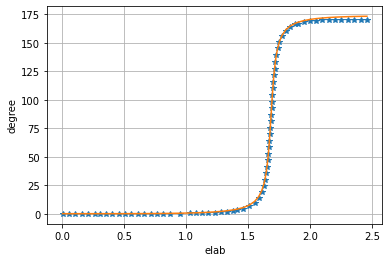

In [16]:
# ERE with 2-para 
para, pcov = fit_phase(x = p12C_1p[:,0],y=p12C_1p[:,1],  p0=[-1,-1],fit_function = fit_function_ERE)
L=1;print(para)
print(np.abs(1/para[0])**(1./(2*L+1))*hbarc,  np.abs(0.5*para[1])**(1./(2*L-1))*hbarc)

### ERE with 3-para

para[0] = -8.353770e+00 +/- 1.901676e-01
para[1] = -4.829368e+00 +/- 1.534653e-01
para[2] = -4.587381e+01 +/- 2.165169e+00
[ -8.35376956  -4.82936774 -45.8738059 ]
97.25059768427421 476.482246426736 163.4391736190747


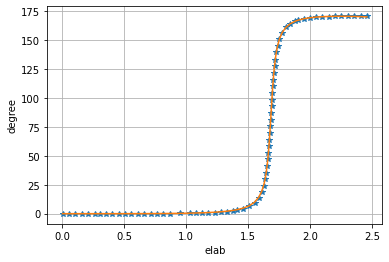

In [17]:
# ERE with 3-para 
# This case the fit is rather stable, not sensitive to initial values 
para, pcov = fit_phase(x = p12C_1p[:,0],y=p12C_1p[:,1],  p0=[-2,-1,-1],fit_function = fit_function_ERE)
L=1;print(para)
print(np.abs(1/para[0])**(1./(2*L+1))*hbarc,  np.abs(0.5*para[1])**(1./(2*L-1))*hbarc, np.abs(0.25*para[1])**(1./(2*L-3))*hbarc)

### EFT with 2-para = ERE with 2-para

para[0] = -1.573699e+01 +/- 1.660161e-01
para[1] = -1.618752e+00 +/- 1.936683e-02
[-15.73698918  -1.6187525 ]
78.7431095047383 159.7117612769308


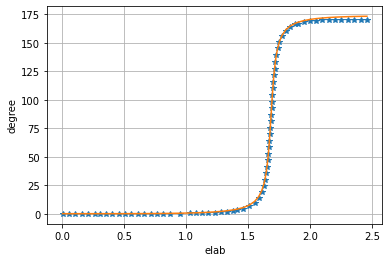

In [18]:
# EFT with 2-para ~ equivalent to ERE
para, pcov = fit_phase(x = p12C_1p[:,0],y=p12C_1p[:,1],  p0=[-1,-1],fit_function = fit_function_EFT)
L=1;print(para)
print(np.abs(1/para[0])**(1./(2*L+1))*hbarc,  np.abs(0.5*para[1])**(1./(2*L-1))*hbarc)

### ERE with 3-para

However, the fitting is very sensitive to initial points.
Also, there is not much improvement from 2-para fit.

__Essentially the fit is not good with this form__

para[0] = -1.584141e+01 +/- 3.603589e-01
para[1] = -1.602965e+00 +/- 4.752401e-02
para[2] = 1.080258e-01 +/- 2.018681e-01
[-15.84140796  -1.60296538   0.10802577]
78.56971600393898 158.15414916071379 492.40481526039383


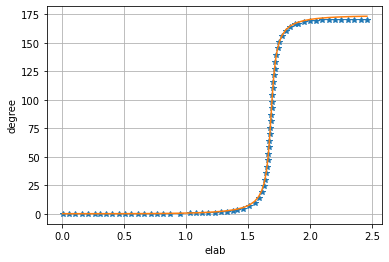

In [19]:
# EFT with 3-para
# sensitive to the initial values
# meaning there are many local minima. 
# Difficult to find a good fitting values...
para, pcov = fit_phase(x = p12C_1p[:,0],y=p12C_1p[:,1],  p0=[ -15 , -2, -0.1 ],fit_function = fit_function_EFT)
L=1;print(para)
print(np.abs(1/para[0])**(1./(2*L+1))*hbarc,  np.abs(0.5*para[1])**(1./(2*L-1))*hbarc, np.abs(0.25*para[1])**(1./(2*L-3))*hbarc)

### To do? 

1. Try to use expansion near resonnance pole ? 

However, eventually, I expect the final result should be similar to ERE form. 
Thus, basically we would not go any further than ERE form and 
need a way to explain the parameter values of ERE. 

__Can we conclude the above results are in reasonable agreement with power counting?__

## Note to myself

Be careful for the default values and global parameters in the function.
Suppose following function

    x=1;y=2;
    def ff(y=y):
        print(x,y)

the output of the function changes if x value is changed globally.
However, the output does not change if y value changed globally. 

    ff() --> gives (1,2)
    x=2;y=3;
    ff() --> gives (2,2) 
    
__If a default value is given as a global parameter, it should always be a constant !__    